# UNIVARIATE NONLINEAR REGRESSION

In [17]:
import numpy
import pandas
import tensorflow
from tensorflow import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, r2_score
from tensorflow.python.client import device_lib

%matplotlib inline

In [18]:
tensorflow.config.list_physical_devices('GPU')

[]

In [19]:
# tensorflow.debugging.set_log_device_placement(True)

## INPUT PARAMETERS HERE

In [20]:
# DATA PARAMETERS
file_path = '../../../dataset/iris.data'

var_types = {'petallength' : 'float',
             'petalwidth' : 'float',
             'sepallength' : 'float',
             'sepalwidth' : 'float',
             'flower' : 'str'}

# COOK PARAMETERS
reg_col = 'petallength'
folding_sampler = 'flower'
my_metric = 'mse'
relevant_features = 4
my_patience = 50
min_improvement = 0.01
min_neuron_gain = 0.025
random_seed = 42
n_k_folds = 5
learning_rate = 0.01
hidden_activations = ['linear', 'sigmoid']
print_anyway = True
rollback_on_no_bound_gain = True
my_optimizers = ['adam']

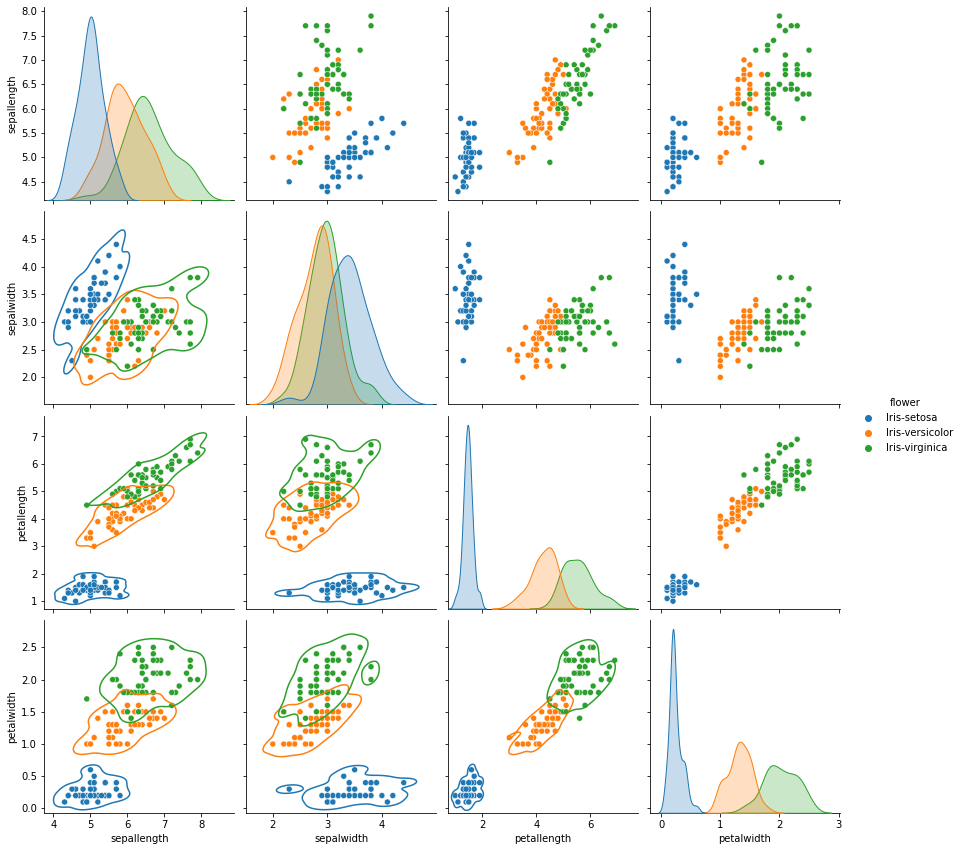

In [21]:
# IMPORT AND CONVERT
df = pandas.read_csv((file_path))
for input_col in var_types.keys():
    df[input_col] = df[input_col].astype(var_types[input_col])

# SCATTER PLOT
g = seaborn.pairplot(df, hue='flower', height=3, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

## ROBUST COOKING

In [22]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# QUANTIFY REPRESENTATION 
dfn_mi_list = []
dfn_data_list = []
for my_var in var_types.keys():
    if my_var == reg_col:
        col_class = 'Y'
    else:
        col_class = 'X'

    if var_types[my_var] == 'float': # NUMERIC DATA
        dfn_mi_list.append((col_class, 'continuous', my_var))
        dfn_data_list.append(df[[my_var]].values)

    elif var_types[my_var] == 'str': # CATEGORICAL DATA
        one_hot = OneHotEncoder(sparse=False)
        var_cat = df[[my_var]].to_numpy()
        one_hot.fit(var_cat)
        cat_df = pandas.DataFrame(one_hot.transform(var_cat))
        cat_df.columns = one_hot.categories_
        for cat in cat_df.columns:
            dfn_mi_list.append((col_class, 'categorical', cat[0]))
            dfn_data_list.append(cat_df[[cat]].values)

dfn_mi = pandas.MultiIndex.from_tuples(dfn_mi_list)
dfn = pandas.DataFrame(index=df.index, columns=dfn_mi, data=numpy.concatenate(dfn_data_list, axis=1))
dfn = dfn.sort_index(axis=1)
dfn

X                                                        \
    categorical                                continuous               
    Iris-setosa Iris-versicolor Iris-virginica petalwidth sepallength   
0           1.0             0.0            0.0        0.2         5.1   
1           1.0             0.0            0.0        0.2         4.9   
2           1.0             0.0            0.0        0.2         4.7   
3           1.0             0.0            0.0        0.2         4.6   
4           1.0             0.0            0.0        0.2         5.0   
..          ...             ...            ...        ...         ...   
145         0.0             0.0            1.0        2.3         6.7   
146         0.0             0.0            1.0        1.9         6.3   
147         0.0             0.0            1.0        2.0         6.5   
148         0.0             0.0            1.0        2.3         6.2   
149         0.0             0.0            1.0        1.8         5.9   

                         Y  
                continuous  
    sepalwidth petallength  
0          3.5         1.4  
1          3.0         1.4  
2          3.2         1.3  
3          3.1         1.5  
4          3.6         1.4  
..         ...         ...  
145        3.0         5.2  
146        2.5         5.0  
147        3.0         5.2  
148        3.4         5.4  
149        3.0         5.1  

[150 rows x 7 columns]

In [23]:
# NUMPY MATRIX FOR TRAINING
X = dfn['X'].to_numpy()
my_vars = list(dfn['X'].columns.get_level_values(1))
Y = dfn['Y'].to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# TRANSFORM Y
Y_scaler = None
if var_types[reg_col] == 'float': # IF REGRESSION NORMALIZE
    Y_scaler = StandardScaler()
    Y_scaler = Y_scaler.fit(Y)
    Y_scaled = Y_scaler.transform(Y)
else:
    Y_scaled = Y

# Y SAMPLING
Y_sample = df[[folding_sampler]].to_numpy()

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_sample)

# TRAINING LOOP
n_classes = dfn['Y'].columns.shape[0]
hidden_layers = 1

# PATTERN SEARCH
search_vector = numpy.identity(len(hidden_activations), dtype=int)
current_configurations = search_vector

still_searching = True
best_net_name = None
best_net = None
best_config = None

if my_metric == 'mse':
    my_mode = 'min'
    best_metric = 1.0
    best_metric_val = 1.0
    metric_bound = 1000.0
else:
    my_mode = 'max'
    best_metric = 0.0
    best_metric_val = 0.0
    metric_bound = 0.0


result_list = []

# RUNNING ON GPU AND CPU
strategy = tensorflow.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [24]:
print('COOKING BEST NETWORK STARTED...\n')
while still_searching:
    for net_config in current_configurations:
        print('CONFIG: {}'.format(net_config))
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y_sample):
            print('FOLD: {}/{}'.format(ix_fold, n_k_folds))

            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y_scaled[train_index], Y_scaled[test_index]
            for optimizer in my_optimizers:

                # Open a strategy scope and create/restore the model
                with strategy.scope():
                    # DECLARE OPTIMIZERS INSIDE SCOPE
                    _optimizers = {'adagrad': tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate),
                                   'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate),
                                   'adam': tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)}
                    # DECLARE NET
                    inputs = keras.Input(shape=(X_train.shape[1], ))
                    hidden_layer_list = []
                    net_name = ''
                    for ix_activation in numpy.arange(len(net_config)):
                        f_activation = hidden_activations[ix_activation]
                        n_neuron = net_config[ix_activation]
                        if n_neuron > 0:
                            temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                            hidden_layer_list.append(temp_hidden_layer)
                            net_name += '{}{}'.format(f_activation, n_neuron)
                    if len(hidden_layer_list) > 1:
                        hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                    else:
                        hidden = hidden_layer_list[0]
                    outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                    model_name = '{}_{}_F{}_WRAPPER'.format(net_name.upper(), optimizer.upper(), ix_fold)
                    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                                                                         patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0],
                                    epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # CALCULATE VARIABLE RELEVANCE
                Y_est = my_net.predict(X_scaled, verbose=0)
                relevance_dict = {}
                for feature in my_vars:
                    X_relevance = numpy.copy(X_scaled)
                    X_relevance[:, my_vars == feature] = 0.0
                    Y_est_relevance = my_net.predict(X_relevance, verbose=0)
                    Y_relevance = (Y_est - Y_est_relevance)**2
                    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
                    relevance_dict[feature] = feature_relevance
                s_relevance = pandas.Series(relevance_dict)
                s_relevance_norm = s_relevance/s_relevance.max()
                s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
                selected_features = list(s_relevance_norm.index.values)
                selected_relevance = list(100.0*s_relevance_norm.values)

                # FINAL NET
                with strategy.scope():
                    inputs = keras.Input(shape=(len(selected_features), ))
                    hidden_layer_list = []
                    net_name = ''
                    for ix_activation in numpy.arange(len(net_config)):
                        f_activation = hidden_activations[ix_activation]
                        n_neuron = net_config[ix_activation]
                        if n_neuron > 0:
                            temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                            hidden_layer_list.append(temp_hidden_layer)
                            net_name += '{}{}'.format(f_activation, n_neuron)
                    if len(hidden_layer_list) > 1:
                        hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                    else:
                        hidden = hidden_layer_list[0]
                    outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                    model_name = '{}_{}_F{}'.format(net_name.upper(), optimizer.upper(), ix_fold)
                    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                ix_relevant = dfn['X'].columns.get_level_values(1).isin(selected_features)
                history = my_net.fit(X_train[:, ix_relevant], Y_train, validation_data=(X_test[:, ix_relevant], Y_test), batch_size=X_train.shape[0],
                                    epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if my_mode == 'max':
                    is_best = ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement))
                elif my_mode == 'min':
                    is_best = ((metric_val < best_metric - min_improvement) & (val_metric_val <= best_metric_val)) | ((metric_val <= best_metric) & (val_metric_val < best_metric_val - min_improvement))

                if is_best:
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_config = net_config
                    best_features = selected_features
                    best_relevance = selected_relevance
                    best_net = my_net
                    best_neurons = net_config.sum()
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'net_config': net_config, 'neurons': net_config.sum(), 'fold': ix_fold, 'features': selected_features, 'relevance': selected_relevance, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)
                if is_best or print_anyway:
                    print('{}_{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.2f} {}: {:.2f} {}'.format(model_name,'_'.join(selected_features), n_epochs, model_loss, model_val_loss, metric_name, metric_val, val_metric_name, val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                if my_mode == 'max':
                    maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                elif my_mode == 'min':
                    maximized_metrics = (val_metric_val == 0.0) & (metric_val == 0.0)

                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            ix_fold += 1

        if maximized_metrics:
            break

    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    total_neurons = net_config.sum()

    if total_neurons > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < total_neurons:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(total_neurons, metric_name))
            break
    
    # CALCULATE CONFIG BOUND
    df_results = pandas.DataFrame(result_list)
    ix_config = numpy.array([numpy.linalg.norm(best_config - x) for x in df_results.net_config]) == 0.0
    if my_mode == 'max':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].min()
    elif my_mode == 'min':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].max()

    # TEST IF LOWER BOUND IMPROVED
    bound_didnt_improve = False
    if total_neurons > 1:
        neuron_gain = 0.0
        if my_mode == 'max':
            if bound_est > metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = bound_est/metric_bound - 1.0
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break
        elif my_mode == 'min':
            if bound_est < metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = 1.0 - bound_est/metric_bound
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break

    else:
        print('BEST CONFIG {} & best quality for {}: {:.2f}'.format(best_config, best_optimizer.upper(), bound_est))
    
    metric_bound = bound_est

    # ALTER CONFIG FROM BEST CONFIG IF NEEDED
    if maximized_metrics or dont_need_extra_neurons or bound_didnt_improve:
        still_searching = False
    else:
        current_configurations = best_config + search_vector

COOKING BEST NETWORK STARTED...

CONFIG: [1 0]
FOLD: 1/5


2022-08-16 08:13:22.596600: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_109908"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:9042"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

LINEAR1_ADAM_F1_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 159 loss: 0.05 val_loss: 0.05 mse: 0.05 val_mse: 0.05 **Best NET!**
FOLD: 2/5


2022-08-16 08:13:48.955547: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_163973"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:13493"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1_ADAM_F2_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 118 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 3/5


2022-08-16 08:14:06.054410: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_199830"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:16494"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1_ADAM_F3_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 126 loss: 0.07 val_loss: 0.09 mse: 0.07 val_mse: 0.09 
FOLD: 4/5


2022-08-16 08:14:26.149669: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_243179"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:20045"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1_ADAM_F4_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 62 loss: 0.05 val_loss: 0.04 mse: 0.05 val_mse: 0.04 
FOLD: 5/5


2022-08-16 08:14:42.517820: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_279240"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:23046"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1_ADAM_F5_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 175 loss: 0.05 val_loss: 0.06 mse: 0.05 val_mse: 0.06 
CONFIG: [0 1]
FOLD: 1/5


2022-08-16 08:15:09.283788: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_333154"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:27497"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID1_ADAM_F1_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 162 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 2/5


2022-08-16 08:17:16.424325: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_391892"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:32288"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID1_ADAM_F2_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 183 loss: 0.04 val_loss: 0.06 mse: 0.04 val_mse: 0.06 
FOLD: 3/5


2022-08-16 08:19:21.389959: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_454474"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:37389"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID1_ADAM_F3_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 184 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 4/5


2022-08-16 08:20:33.912225: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_517244"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:42510"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID1_ADAM_F4_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 132 loss: 0.05 val_loss: 0.03 mse: 0.05 val_mse: 0.03 
FOLD: 5/5


2022-08-16 08:22:15.268080: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_576354"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:47331"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID1_ADAM_F5_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 162 loss: 0.04 val_loss: 0.03 mse: 0.04 val_mse: 0.03 **Best NET!**
BEST CONFIG [0 1] & best quality for ADAM: 0.06
CONFIG: [1 1]
FOLD: 1/5


2022-08-16 08:24:21.331589: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_649453"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:53342"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1SIGMOID1_ADAM_F1_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 88 loss: 0.05 val_loss: 0.05 mse: 0.05 val_mse: 0.05 
FOLD: 2/5


2022-08-16 08:25:02.425898: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_678615"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:55763"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1SIGMOID1_ADAM_F2_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 102 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 3/5


2022-08-16 08:26:07.796525: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_724653"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:59424"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1SIGMOID1_ADAM_F3_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 79 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 4/5


2022-08-16 08:27:05.167798: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_756191"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:61965"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1SIGMOID1_ADAM_F4_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 131 loss: 0.06 val_loss: 0.04 mse: 0.06 val_mse: 0.04 
FOLD: 5/5


2022-08-16 08:28:08.615199: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_803993"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:65716"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

LINEAR1SIGMOID1_ADAM_F5_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 98 loss: 0.05 val_loss: 0.05 mse: 0.05 val_mse: 0.05 
CONFIG: [0 2]
FOLD: 1/5


2022-08-16 08:29:12.412835: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_837828"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:68437"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID2_ADAM_F1_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 166 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 2/5


2022-08-16 08:30:03.844987: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_876602"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:71618"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID2_ADAM_F2_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 67 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 3/5


2022-08-16 08:31:10.513652: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_917412"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:74999"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID2_ADAM_F3_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 141 loss: 0.04 val_loss: 0.05 mse: 0.04 val_mse: 0.05 
FOLD: 4/5


2022-08-16 08:32:16.178552: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_956026"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:78200"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID2_ADAM_F4_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 188 loss: 0.05 val_loss: 0.03 mse: 0.05 val_mse: 0.03 
FOLD: 5/5


2022-08-16 08:33:26.430785: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_999884"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:81791"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 120
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

SIGMOID2_ADAM_F5_Iris-setosa_Iris-versicolor_Iris-virginica_petalwidth > epochs: 82 loss: 0.05 val_loss: 0.04 mse: 0.05 val_mse: 0.04 
NETs w 2 neurons didnt improve mse!


In [25]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
if bound_didnt_improve and rollback_on_no_bound_gain:
    best_row = df_results[(df_results.neurons == best_config.sum() - 1) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_config = best_row['net_config'].values[0]
    best_features = best_row['features'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]

In [26]:
# PREDICT
ix_best_features = dfn['X'].columns.isin(best_features, level=1)
Y_est_scaled = best_net.predict(X_scaled[:, ix_best_features], verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)

# PLOT Y Vs YEST
df_result = pandas.DataFrame(index=df.index)
df_result['Y'] = Y
df_result['Y_est'] = Y_est
df_result['r'] = df_result['Y_est'] - df_result['Y']
df_result['rabs'] = df_result['r'].abs()
df_result = df_result.join(df.loc[:, df.columns != reg_col])

df_result

2022-08-16 08:34:25.542965: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1042138"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:85342"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_

,Y,Y_est,r,rabs,sepallength,sepalwidth,petalwidth,flower
0,1.4,1.497004,0.097004,0.097004,5.1,3.5,0.2,Iris-setosa
1,1.4,1.497004,0.097004,0.097004,4.9,3.0,0.2,Iris-setosa
2,1.3,1.497004,0.197004,0.197004,4.7,3.2,0.2,Iris-setosa
3,1.5,1.497004,-0.002996,0.002996,4.6,3.1,0.2,Iris-setosa
4,1.4,1.497004,0.097004,0.097004,5.0,3.6,0.2,Iris-setosa
...,...,...,...,...,...,...,...,...
145,5.2,5.681056,0.481056,0.481056,6.7,3.0,2.3,Iris-virginica
146,5.0,5.573483,0.573483,0.573483,6.3,2.5,1.9,Iris-virginica
147,5.2,5.607918,0.407918,0.407918,6.5,3.0,2.0,Iris-virginica
148,5.4,5.681056,0.281056,0.281056,6.2,3.4,2.3,Iris-virginica


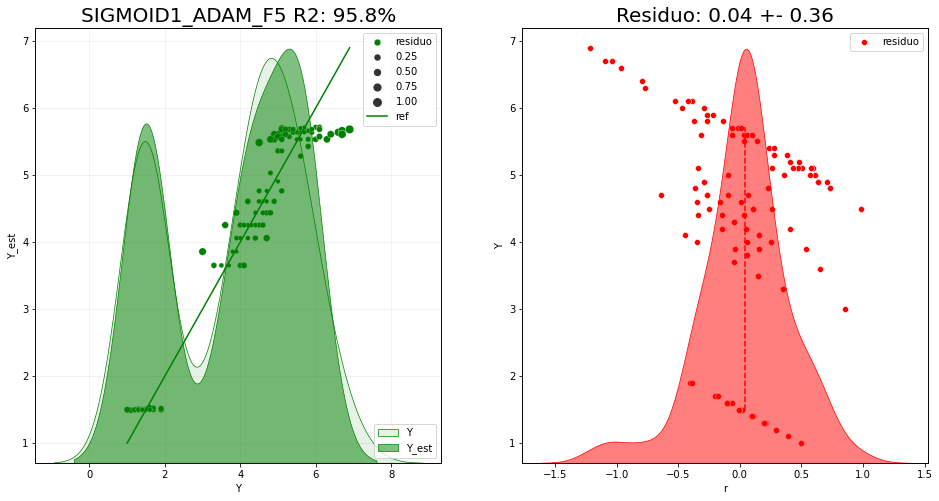

In [27]:
# STABLE RESIDUAL PLOT
r_mean = df_result.r.median()
r_std = df_result.r.std()
r2 = r2_score(df_result.Y.to_numpy(), df_result.Y_est.to_numpy())

fig = pyplot.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
lines = seaborn.scatterplot(data=df_result, x='Y', y='Y_est', size='rabs', ax=ax, label='residuo', color='green')
_ = ax.plot([df_result.Y.min(), df_result.Y.max()], [df_result.Y.min(), df_result.Y.max()], color='green', label='ref')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(best_net_name,100.0*r2), size=20)
ax2 = ax.twinx()
_ = seaborn.kdeplot(data=df_result, x='Y', ax=ax2, label='Y', color='green', fill=True, alpha=0.1, linewidth=0.7)
_ = seaborn.kdeplot(data=df_result, x='Y_est', ax=ax2, label='Y_est', color='green', fill=True, alpha=0.5, linewidth=0.7)
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
_ = ax.legend(loc='upper right')
_ = ax2.legend(loc='lower right')
ax3 = fig.add_subplot(122)
_ = seaborn.scatterplot(data=df_result, x='r', y='Y', ax=ax3, label='residuo', color='red')
ax4 = ax3.twinx()
_ = seaborn.kdeplot(data=df_result, x='r', ax=ax4, label='residuo', color='red', fill=True, alpha=0.5, linewidth=0.7)
_ = ax4.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title('Residuo: {:.2f} +- {:.2f}'.format(r_mean, r_std), size=20)
_ = ax3.plot([r_mean, r_mean], [df_result.Y_est.min(), df_result.Y_est.max()], '--', color='red')

In [28]:
df_result.Y_est.max()

5.7117719650268555

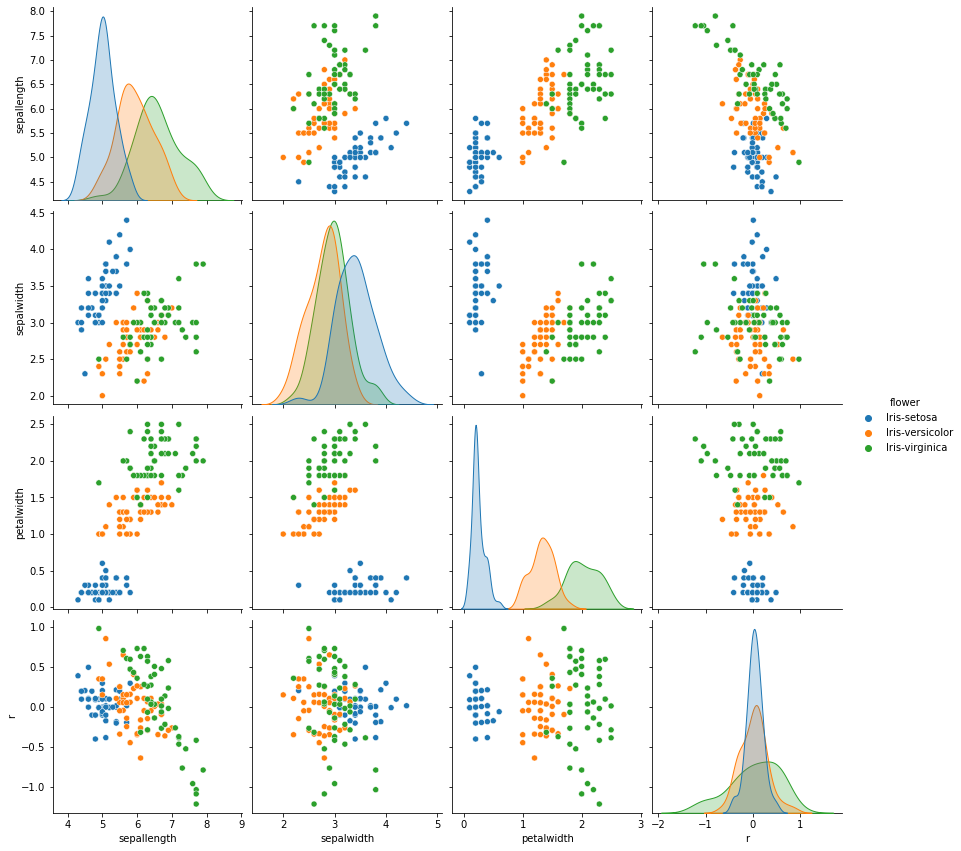

In [29]:
# SCATTER PLOT
resplot_var = list(df.columns[df.columns != reg_col])
resplot_var.append('r')
g2 = seaborn.pairplot(df_result[resplot_var], hue='flower', height=3, diag_kind='kde')
# _ = g2.map_lower(seaborn.kdeplot, levels=1, color=".2")